In [1]:
import cv2
#INSTALAR OPENCV
import os
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import scipy.spatial as sp
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
matplotlib.use('QtAgg')
%matplotlib inline
rcParams['figure.figsize'] = 16, 10

In [3]:
boundaries = [
    ([153/360*255,100,60], [180/360*255,255,255]), #red
    ([60/360*255,100,60], [100/360*255,255,255]), #green
    ([0/360*255,100,60], [30/360*255,255,255]), #blue
    ([135/360*255,100,60],[140/360*255,255,255]), #yellow
    ([140/360*255,100,60], [153/360*255,255,255]), #orange
    ([200/360*255,100,60],[360/360*255,255,255]), #pink
    ([30/360*255,100,60],[60/360*255,255,255]), #cyan
    ([0,0,180],[255,60,255]), #white
    ([0,0,50],[255,60,180]), #gray
    ([0,0,0],[255,60,50]) #black
    ]
colors = [(214,39,40), # red
          (0,0,0), # gray
          (44,160,44), # green
          (31,68,180), # blue
          (14,127,255), # yellow
          (255,127,14), # orange
          (214,39,40), # pink
          (23,190,207), # cyan
          (0,0,0),# white
          (0,0,0), # gray
          (0,0,0) # black
         ]

cnames = ['blue',
          'green',
          'red',
          'cyan',
          'orange',
          'pink',
          'yellow',
          'white',
          'gray',
          'black'
         ]

In [112]:
def calibrate(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # define range of green color in HSV
    b = np.histogram(hsv[:,:,0].flatten(), range(255))
    thresh  = 0.1*max(b[0]) #Talvez usar terceiro quartil seja melhor?
    f = b[0] > thresh
    m = b[1][:-1][f]
    mask_low = np.array([min(m), 80, 50])
    mask_up = np.array([max(m), 255, 255])
    return mask_low, mask_up

def get_field(frame, lower=None, upper=None):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    if isinstance(lower,type(None)):
        # define range of blue color in HSV
        b = np.histogram(hsv[:,:,0].flatten(), range(255))
        thresh  = 0.0000001*max(b[0])
        f = b[0] > thresh
        m = b[1][:-1][f]
        lower = np.array([min(m), 50, 20])
        upper = np.array([max(m), 255, 255])
    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower, upper)
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(frame,frame, mask= mask)
    return res, b, m

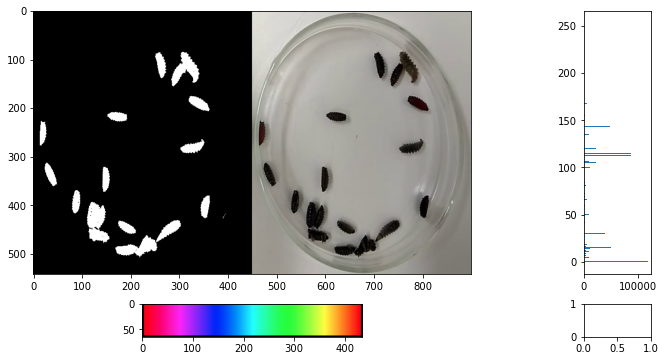

In [242]:
fig, ax = plt.subplots(2,2,figsize=(12,6), gridspec_kw={'height_ratios': [8, 1], 'width_ratios': [8, 1]})
img = cv2.imread('Larvas/Videos/frames/C_30_1.mp4_297.png')
#res,b, m = get_field(img)
#res = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
#res = cv2.threshold(res, 0, 255, cv2.THRESH_BINARY_INV+ cv2.THRESH_TRIANGLE)[1]
res = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
res = cv2.threshold(res, 75, 255, cv2.THRESH_BINARY_INV)[1] # C_20_1
#res = cv2.threshold(res, 35, 255, cv2.THRESH_BINARY_INV)[1] # C_20_1
#res = cv2.threshold(res, 50, 255, cv2.THRESH_BINARY_INV)[1] # C_13_1 C_15_1 C_18_1 C_25_2
#res = cv2.threshold(res, 75, 255, cv2.THRESH_BINARY_INV)[1] # C_5_1 C_10_1 C_30_1
#res = cv2.threshold(res, 80, 255, cv2.THRESH_BINARY_INV)[1] # C_0_1 C_25_1
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_img = np.stack([res,res,res],axis=2)
side = np.hstack([new_img,img])
ax[0][0].imshow(side, cmap ='gray')
ax[0][1].barh(range(254),b[0])
img2 = cv2.imread('hues.png')
hsv = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
lower = np.array([0, 50, 20])
upper = np.array([180, 255, 255])
mask = cv2.inRange(hsv, lower, upper)
img2 = cv2.bitwise_and(img2,img2, mask= mask)
ax[1][0].imshow(img2)
#print('Faixa de hue: {}'.format(m))

In [243]:
vv

'C_25_1.mp4'

In [256]:
fourcc = cv2.VideoWriter_fourcc('H','2','6','4')
distancias_c = {}
#distancias_m = {}
distancias_e = {}
tamanhos = {}
thresh = {'C_0_1.mp4':80,
          'C_5_1.mp4':75,
          'C_10_1.mp4':75,
          'C_13_1.mp4':50,
          'C_15_1.mp4':50,
          'C_18_1.mp4':50,
          'C_20_1.mp4':35,
          'C_25_1.mp4':80,
          'C_25_2.mp4':50,
          'C_30_1.mp4':75,
         }
for vv in os.listdir('Novos/'):
    cap= cv2.VideoCapture('Novos/{}'.format(vv))
    video = cv2.VideoWriter('Larvas/Videos/{}'.format(vv), fourcc, cap.get(5), (2*int(cap.get(3)), int(cap.get(4))))
    previous = 0
    dist_c = []
    dist_m = []
    dist_e = []
    print(vv)
    t = 0
    tamanhos[vv] = int(cap.get(3)*cap.get(4))
    while True:
        ret, img = cap.read()
        if (ret == False) | (isinstance(img,type(None))):
            break
        #res = get_field(img)
        res = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        limiar = thresh[vv]
        res = cv2.threshold(res, limiar, 255, cv2.THRESH_BINARY_INV)[1]
        #res = cv2.threshold(res, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        new_img = np.stack([res,res,res],axis=2)
        side = np.hstack([new_img,img])
        font = cv2.FONT_HERSHEY_SIMPLEX
        xx = int(cap.get(3))
        yy = int(cap.get(4))
        cv2.putText(side, vv, (int(cap.get(3)+10), 32), font, 0.5,(0,0,0))
        cv2.putText(side,"tamanho =  {}x{}".format(xx,yy) , (int(cap.get(3)+10), 64), font, 0.5,(0,0,0))
        video.write(side)
        #if t%99 == 0:
        #    plt.imsave('Larvas/Videos/frames/{}_{}.png'.format(vv,t), cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if not isinstance(previous, int):
            dist_c.append(sp.distance.cosine(previous.flatten(), res.flatten()))
            #dist_m.append(sp.distance.mahalanobis(previous.flatten(), res.flatten(), np.cov(previous.flatten(), res.flatten())))
            dist_e.append(sp.distance.euclidean(previous.flatten(), res.flatten()))
        previous = res.copy()
        t +=1 
    distancias_c[vv] = dist_c
    #distancias_m[vv] = dist_m
    distancias_e[vv] = dist_e
    video.release()
    cap.release()
    cv2.destroyAllWindows()

OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


C_25_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


C_5_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


C_15_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


C_13_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


C_30_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


C_20_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


C_0_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


C_18_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


C_10_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


C_25_1.mp4


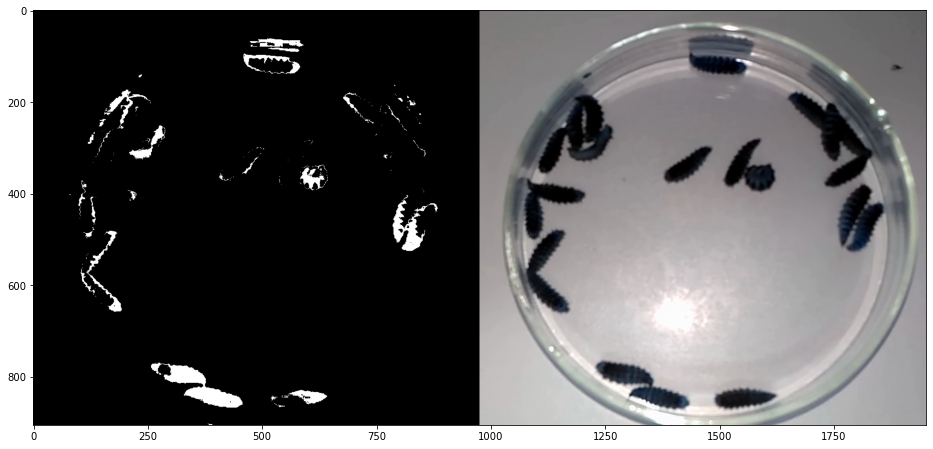

In [41]:
plt.imshow(final)

In [10]:
for vv in os.listdir('Novos/'):
    print(vv)

C_25_2.mp4
C_5_1.mp4
C_15_1.mp4
C_13_1.mp4
C_30_1.mp4
C_20_1.mp4
C_0_1.mp4
C_18_1.mp4
C_10_1.mp4
C_25_1.mp4


In [247]:
final_c = []
final_e = []
for d in distancias_c.keys():
    final_c.append(np.mean(distancias_c[d]))
    final_e.append(np.mean(distancias_e[d]))

In [258]:
df = {'video':distancias_c.keys(),
      'media_euclidiana':final_e,
      'media_cossenos':final_c,
      'tamanho_video': tamanhos.values()}
df = pd.DataFrame(df)

In [259]:
f = lambda x: int(x.split('_')[1])
n = df['video'].apply(f)

In [260]:
df['concentracao'] = n

In [264]:
df = df.sort_values('concentracao')
df

,video,media_euclidiana,media_cossenos,tamanho_video,concentracao
6,C_0_1.mp4,11597.527592,0.015915,2073600,0
1,C_5_1.mp4,10592.189822,0.036566,437220,5
8,C_10_1.mp4,8439.760857,0.066519,246000,10
3,C_13_1.mp4,17738.159115,0.073165,884256,13
2,C_15_1.mp4,19102.249627,0.079536,921312,15
7,C_18_1.mp4,5946.028144,0.034391,307584,18
5,C_20_1.mp4,5611.194800,0.024549,285012,20
0,C_25_2.mp4,5091.617378,0.024123,303260,25
9,C_25_1.mp4,11779.217750,0.047033,786760,25
4,C_30_1.mp4,3797.917642,0.017284,243900,30


In [266]:
df['media_euclidiana_dividida'] = df['media_euclidiana']/df['tamanho_video']
df['media_cossenos_dividida'] = df['media_cossenos']/df['tamanho_video']
df

,video,media_euclidiana,media_cossenos,tamanho_video,concentracao,media_euclidiana_dividida,media_cossenos_dividida
6,C_0_1.mp4,11597.527592,0.015915,2073600,0,0.005593,7.674910e-09
1,C_5_1.mp4,10592.189822,0.036566,437220,5,0.024226,8.363282e-08
8,C_10_1.mp4,8439.760857,0.066519,246000,10,0.034308,2.704043e-07
3,C_13_1.mp4,17738.159115,0.073165,884256,13,0.020060,8.274208e-08
2,C_15_1.mp4,19102.249627,0.079536,921312,15,0.020734,8.632891e-08
7,C_18_1.mp4,5946.028144,0.034391,307584,18,0.019331,1.118114e-07
5,C_20_1.mp4,5611.194800,0.024549,285012,20,0.019688,8.613466e-08
0,C_25_2.mp4,5091.617378,0.024123,303260,25,0.016790,7.954464e-08
9,C_25_1.mp4,11779.217750,0.047033,786760,25,0.014972,5.978003e-08
4,C_30_1.mp4,3797.917642,0.017284,243900,30,0.015572,7.086479e-08


In [271]:
df.to_csv('Larvas/larvas.csv')

<AxesSubplot:xlabel='concentracao', ylabel='media_cossenos_dividida'>

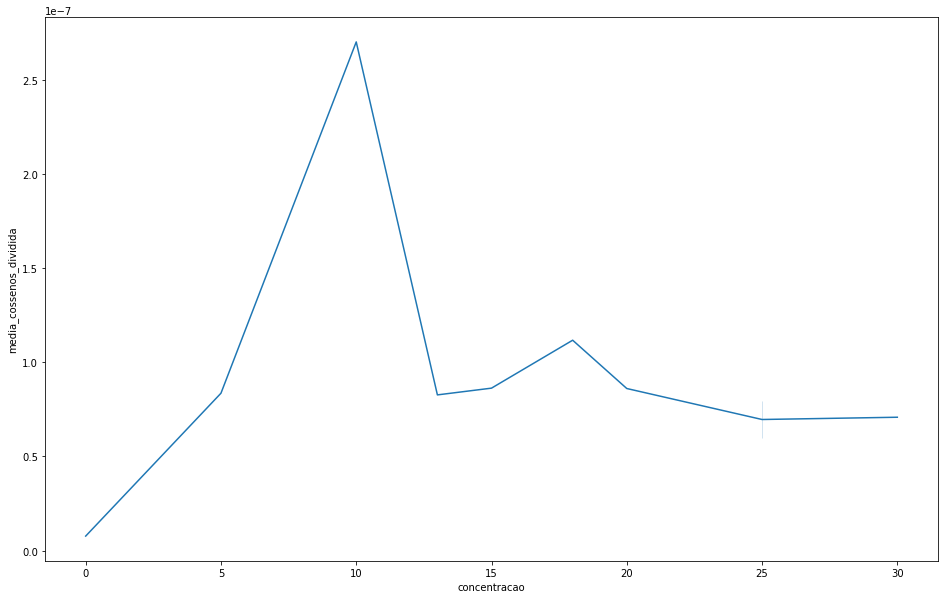

In [268]:
sns.lineplot(data=df, x='concentracao', y='media_cossenos_dividida')

<AxesSubplot:xlabel='concentracao', ylabel='media_euclidiana_dividida'>

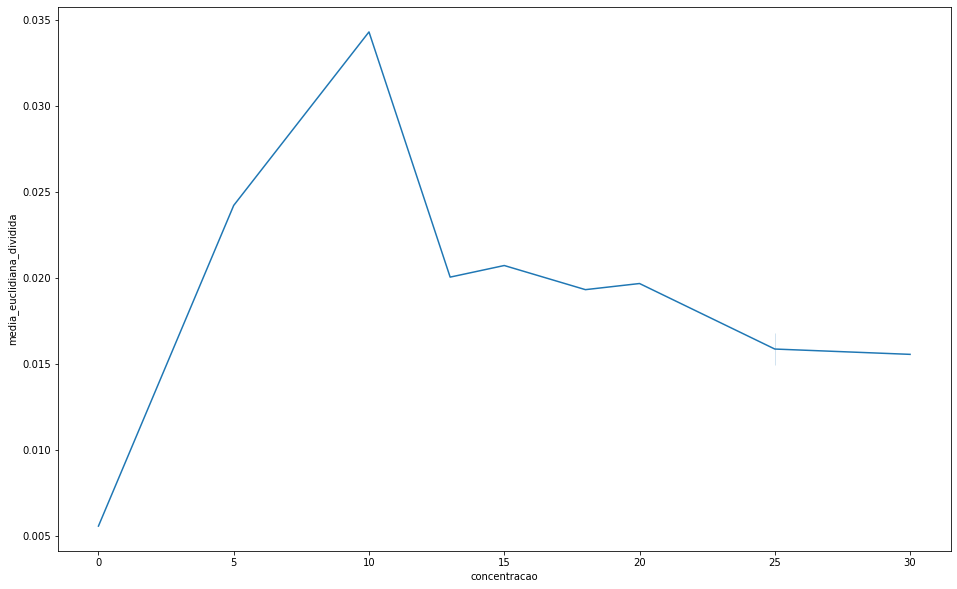

In [270]:
sns.lineplot(data=df, x='concentracao', y='media_euclidiana_dividida')

In [3]:
data = pd.read_csv('result.csv', index_col=0)
data

,conc,media_euclidiana,media_cossenos,n_lavas,larvae_mov,frac_pupae
0,0.00,15499.080009,0.121243,6.0,0.020207,0.70
1,0.79,13572.592105,0.115029,18.0,0.006391,0.10
2,1.59,9926.058430,0.147493,19.0,0.007763,0.05
3,2.07,16742.513400,0.225715,20.0,0.011286,0.00
4,2.38,13452.775761,0.411842,19.0,0.021676,0.05
5,2.86,4103.165078,0.161264,7.0,0.023038,0.65
6,3.18,3854.914603,0.307600,6.0,0.051267,0.70
7,3.98,9919.793351,0.156371,11.0,0.014216,0.45
8,4.77,5026.909298,0.103959,3.0,0.034653,0.85


In [5]:
pupa = pd.read_csv('data_pupa.csv', index_col=0)
pupa

,width,diam
conc,,
0.00,8.6,3.3
0.00,8.8,3.6
0.00,8.7,3.3
0.00,8.5,3.2
0.00,8.8,3.2
...,...,...
4.77,7.8,2.9
4.77,8.2,2.7
4.77,8.2,3.1
